# Vehicle Routing

## The Introduction

Logistics is a major industry, with some estimates valuing it at USD 8183 billion globally in 2015. Most service providers operate a number of vehicles (e.g., trucks and container ships), a number of depots, where the vehicles are based overnight, and serve a number of client locations with each vehicle during each day. There are many optimization and control problems that consider these parameters. Computationally, the key challenge is how to design routes from depots to a number of client locations and back to the depot, so as to minimize vehicle-miles traveled, time spent, or similar objective functions. In this notebook we formalize an idealized version of the problem and showcase its solution using the quantum approximate optimization approach of Farhi, Goldstone, and Gutmann (2014). 

The overall workflow we demonstrate comprises:

1. establish the client locations. Normally, these would be available ahead of the day of deliveries from a database. In our use case, we generate these randomly.

2. compute the pair-wise distances, travel times, or similar. In our case, we consider the Euclidean distance, "as the crow flies", which is perhaps the simplest possible.

3. compute the actual routes. This step is run twice, actually. First, we obtain a reference value by a run of a classical solver (IBM CPLEX) on the classical computer. Second, we run an alternative, hybrid algorithm partly on the quantum computer.

4. visualization of the results. In our case, this is again a simplistic plot.

In the following, we first explain the model, before we proceed with the installation of the pre-requisites and the data loading.

## The Model 

Mathematically speaking, the vehicle routing problem (VRP) is a combinatorial problem, wherein the best routes from a depot to a number of clients and back to the depot are sought, given a number of available vehicles. There are a number of formulations possible, extending a number of formulations of the traveling salesman problem [Applegate et al, 2006]. Here, we present a formulation known as MTZ [Miller, Tucker, Zemlin, 1960]. 

Let $n$ be the number of clients (indexed as $1,\dots,n$), and $K$ be the number of available vehicles. Let $x_{ij} = \{0,1\}$ be the binary decision variable which, if it is $1$, activates the segment from node $i$ to node $j$. The node index runs from $0$ to $n$, where $0$ is (by convention) the depot. There are twice as many distinct decision variables as edges. For example, in a fully connected graph, there are $n(n+1)$ binary decision variables. 

If two nodes $i$ and $j$ have a link from $i$ to $j$, we write $i \sim j$. We also denote with $\delta(i)^+$ the set of nodes to which $i$ has a link, i.e., $j \in \delta(i)^+$ if and only if $i \sim j$. Similarly, we denote with 
$\delta(i)^-$ the set of nodes which are connected to $i$, in the sense that $j \in \delta(i)^-$ if and only if $j \sim i$. 

In addition, we consider continuous variables, for all nodes $i = 1,\dots, n$, denoted $u_i$. These variables are needed in the MTZ formulation of the problem to eliminate sub-tours between clients. 

The VRP can be formulated as:

$$
(VRP) \quad  f = \min_{\{x_{ij}\}_{i\sim j}\in \{0,1\}, \{u_i\}_{i=1,\dots,n}\in \mathbb{R}} \quad \sum_{i \sim j} w_{ij} x_{ij}
$$

subject to the node-visiting constraint:

$$
\sum_{j \in \delta(i)^+} x_{ij} = 1, \,\sum_{j \in \delta(i)^-} x_{ji} = 1,\, \forall i \in \{1,\dots,n\},
$$

the depot-visiting constraints:

$$
\sum_{i \in \delta(0)^+} x_{0i} = K, \, \sum_{j \in \delta(0)^+} x_{j0} = K,
$$

and the sub-tour elimination constraints:

$$
u_i - u_j + Q x_{ij} \leq Q-q_j, \, \forall i \sim j, \,i ,j \neq 0, \quad q_i \leq u_i \leq Q,\, \forall i, i \neq 0.
$$

In particular, 

- The cost function is linear in the cost functions and weighs the different arches based on a positive weight $w_{ij}>0$ (typically the distance between node $i$ and node $j$);
- The first set of constraints enforce that from and to every client, only one link is allowed;
- The second set of constraints enforce that from and to the depot, exactly  $K$ links are allowed;
- The third set of constraints enforce the sub-tour elimination constraints and are bounds on $u_i$, with $Q>q_j>0$, and $Q,q_i \in \mathbb{R}$.


## Classical solution

We can solve the VRP classically, e.g., by using CPLEX. CPLEX uses a branch-and-bound-and-cut method to find an approximate solution of the VRP, which, in this formulation, is a mixed-integer linear program (MILP). For the sake of notation, we pack the decision variables in one vector as

$$
{\bf z} = [x_{01},x_{02},\ldots,x_{10}, x_{12},\ldots,x_{n(n-1)}]^T,
$$

wherein ${\bf z} \in \{0,1\}^N$, with $N = n (n+1)$. So the dimension of the problem scales quadratically with the number of nodes. Let us denote the optimal solution by ${\bf z}^*$, and the associated optimal cost $f^*$. 


## Quantum solution

Here, we demonstrate an approach that combines classical and quantum computing steps, following the quantum approximate optimization approach of Farhi, Goldstone, and Gutmann (2014). In particular, we use the variational quantum eigensolver (VQE). We stress that given the use of limited depth of the quantum circuits employed (variational forms), it is hard to discuss the speed-up of the algorithm, as the solution obtained is heuristic in nature. At the same time, due to the nature and importance of the target problems, it is worth investigating heuristic approaches, which may be worthwhile for some problem classes. 

The algorithm can be summarized as follows:

- Preparation steps: 
	- Transform the combinatorial problem into a binary polynomial optimization problem with equality constraints only;
	- Map the resulting problem into an Ising Hamiltonian ($H$) for variables ${\bf z}$ and basis $Z$, via penalty methods if necessary;
	- Choose the depth of the quantum circuit $m$. Note that the depth can be modified adaptively.
	- Choose a set of controls $\theta$ and make a trial function $\big|\psi(\boldsymbol\theta)\rangle$, built using a quantum circuit made of C-Phase gates and single-qubit Y rotations, parameterized by the components of $\boldsymbol\theta$.


- Algorithm steps: 
	- Evaluate $C(\boldsymbol\theta) = \langle\psi(\boldsymbol\theta)\big|H\big|\psi(\boldsymbol\theta)\rangle$ by sampling the outcome of the circuit in the Z-basis and adding the expectation values of the individual Ising terms together. In general, different control points around $\boldsymbol\theta$ have to be estimated, depending on the classical optimizer chosen.
	- Use a classical optimizer to choose a new set of controls.
	- Continue until $C(\boldsymbol\theta)$ reaches a minimum, close enough to the solution $\boldsymbol\theta^*$.
	- Use the last $\boldsymbol\theta$ to generate a final set of samples from the distribution $\Big|\langle z_i\big|\psi(\boldsymbol\theta)\rangle\Big|^2\;\forall i$ to obtain the answer.


There are many parameters throughout, notably the choice of the trial wavefunction. Below, we consider:

$$
\big|\psi(\theta)\rangle = [U_\mathrm{single}(\boldsymbol\theta) U_\mathrm{entangler}]^m \big|+\rangle
$$

where $U_\mathrm{entangler}$ is a collection of C-Phase gates (fully-entangling gates), and $U_\mathrm{single}(\theta) = \prod_{i=1}^N Y(\theta_{i})$, where $N$ is the number of qubits and $m$ is the depth of the quantum circuit. 


### Construct the Ising Hamiltonian

From $VRP$ one can construct a binary polynomial optimization with equality constraints only by considering cases in which $K=n-1$. In these cases the sub-tour elimination constraints are not necessary and the problem is only on the variable ${\bf z}$. In particular, we can write an augmented Lagrangian as

$$
(IH) \quad H = \sum_{i \sim j} w_{ij} x_{ij}  + A \sum_{i \in \{1,\dots,n\}} \Big(\sum_{j \in \delta(i)^+} x_{ij} - 1\Big)^2 + A \sum_{i \in \{1,\dots,n\}}\Big(\sum_{j \in \delta(i)^-} x_{ji} - 1\Big)^2 +A \Big(\sum_{i \in \delta(0)^+} x_{0i} - K\Big)^2 + A\Big(\sum_{j \in \delta(0)^+} x_{j0} - K\Big)^2
$$

where $A$ is a big enough parameter. 

### From Hamiltonian to QP formulation 

In the vector ${\bf z}$, and for a complete graph ($\delta(i)^+ = \delta(i)^- = \{0,1,\dots,i-1,i+1,\dots,n\}$), $H$ can be written as follows.

$$
\min_{{\bf z}\in \{0,1\}^{n(n+1)}} {\bf w}^T {\bf z}  + A \sum_{i \in \{1,\dots,n\}} \Big({\bf e}_i \otimes {\bf 1}_n^T {\bf z} - 1\Big)^2 + A \sum_{i \in \{1,\dots,n\}}\Big({\bf v}_i^T {\bf z} - 1\Big)^2 + A \Big(({\bf e}_0 \otimes {\bf 1}_n)^T{\bf z} - K\Big)^2 + A\Big({\bf v}_0^T{\bf z} - K\Big)^2.
$$

That is:

$$
\min_{\bf z\in \{0,1\}^{n(n+1)}} \bf z^T {\bf Q} \bf z + {\bf g}^T \bf z + c,
$$

Where: first term:

$$
{\bf Q} = A \sum_{i \in \{0,1,\dots,n\}}  \Big[({\bf e}_i \otimes {\bf 1}_n)({\bf e}_i \otimes {\bf 1}_n)^T + {\bf v}_i{\bf v}_i^T \Big] 
$$

Second term:

$$
{\bf g} = {\bf w} -2 A \sum_{i \in \{1,\dots,n\}} \Big[({\bf e}_i \otimes {\bf 1}_n) + {\bf v}_i \Big] -2 A K \Big[({\bf e}_0 \otimes {\bf 1}_n) + {\bf v}_0 \Big]
$$

Third term:

$$
c = 2An +2AK^2.
$$

The QP formulation of the Ising Hamiltonian is ready for the use of VQE. We will solve the QP using optimization stack available in Qiskit.



## References

[1] E. Farhi, J. Goldstone, S. Gutmann e-print arXiv 1411.4028, 2014

[2] [Max-Cut and Traveling Salesman Problem](./06_examples_max_cut_and_tsp.ipynb)

[3] C. E. Miller, E. W. Tucker, and R. A. Zemlin (1960). "Integer Programming Formulations and Travelling Salesman Problems". J. ACM. 7: 326–329. doi:10.1145/321043.321046.

[4] D. L. Applegate, R. M. Bixby, V. Chvátal, and W. J. Cook (2006). The Traveling Salesman Problem. Princeton University Press, ISBN 978-0-691-12993-8.

## Initialization

First of all we load all the packages that we need.
CPLEX is required for the classical computations. You can install it by `pip install 'qiskit-optimization[cplex]'`. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import cplex
    from cplex.exceptions import CplexError
except:
    print("Warning: Cplex not found.")
import math

from qiskit.utils import algorithm_globals
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit.algorithms.optimizers import SPSA, NFT, COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Sampler

We then initialize the variables

In [5]:
# Initialize the problem by defining the parameters
n = 4  # number of nodes + depot (n+1)
K = 1  # number of vehicles

We define an initializer class that randomly places the nodes in a 2-D plane and computes the distance between them. 

In [6]:
# Get the data
class Initializer:
    def __init__(self, n):
        self.n = n

    def generate_instance(self):

        n = self.n

        # np.random.seed(33)
        np.random.seed(1543)

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
                instance[jj, ii] = instance[ii, jj]

        return xc, yc, instance

In [7]:
# Initialize the problem by randomly generating the instance
initializer = Initializer(n)
xc, yc, instance = initializer.generate_instance()

## Classical solution using IBM ILOG CPLEX

For a classical solution, we use IBM ILOG CPLEX. CPLEX is able to find the exact solution of this problem. We first define a ClassicalOptimizer class that encodes the problem in a way that CPLEX can solve, and then instantiate the class and solve it. 


In [8]:
class ClassicalOptimizer:
    def __init__(self, instance, n, K):

        self.instance = instance
        self.n = n  # number of nodes
        self.K = K  # number of vehicles

    def compute_allowed_combinations(self):
        f = math.factorial
        return f(self.n) / f(self.K) / f(self.n - self.K)

    def cplex_solution(self):

        # refactoring
        instance = self.instance
        n = self.n
        K = self.K

        my_obj = list(instance.reshape(1, n**2)[0]) + [0.0 for x in range(0, n - 1)]
        my_ub = [1 for x in range(0, n**2 + n - 1)]
        my_lb = [0 for x in range(0, n**2)] + [0.1 for x in range(0, n - 1)]
        my_ctype = "".join(["I" for x in range(0, n**2)]) + "".join(
            ["C" for x in range(0, n - 1)]
        )

        my_rhs = (
            2 * ([K] + [1 for x in range(0, n - 1)])
            + [1 - 0.1 for x in range(0, (n - 1) ** 2 - (n - 1))]
            + [0 for x in range(0, n)]
        )
        my_sense = (
            "".join(["E" for x in range(0, 2 * n)])
            + "".join(["L" for x in range(0, (n - 1) ** 2 - (n - 1))])
            + "".join(["E" for x in range(0, n)])
        )

        try:
            my_prob = cplex.Cplex()
            self.populatebyrow(my_prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs)

            my_prob.solve()

        except CplexError as exc:
            print(exc)
            return

        x = my_prob.solution.get_values()
        x = np.array(x)
        cost = my_prob.solution.get_objective_value()

        return x, cost

    def populatebyrow(self, prob, my_obj, my_ub, my_lb, my_ctype, my_sense, my_rhs):

        n = self.n

        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj=my_obj, lb=my_lb, ub=my_ub, types=my_ctype)

        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        rows = []
        for ii in range(0, n):
            col = [x for x in range(0 + n * ii, n + n * ii)]
            coef = [1 for x in range(0, n)]
            rows.append([col, coef])

        for ii in range(0, n):
            col = [x for x in range(0 + ii, n**2, n)]
            coef = [1 for x in range(0, n)]

            rows.append([col, coef])

        # Sub-tour elimination constraints:
        for ii in range(0, n):
            for jj in range(0, n):
                if (ii != jj) and (ii * jj > 0):

                    col = [ii + (jj * n), n**2 + ii - 1, n**2 + jj - 1]
                    coef = [1, 1, -1]

                    rows.append([col, coef])

        for ii in range(0, n):
            col = [(ii) * (n + 1)]
            coef = [1]
            rows.append([col, coef])

        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)

In [9]:
# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(instance, n, K)

# Print number of feasible solutions
print("Number of feasible solutions = " + str(classical_optimizer.compute_allowed_combinations()))

Number of feasible solutions = 4.0


In [10]:
# Solve the problem in a classical fashion via CPLEX
x = None
z = None
try:
    x, classical_cost = classical_optimizer.cplex_solution()
    # Put the solution in the z variable
    z = [x[ii] for ii in range(n**2) if ii // n != ii % n]
    # Print the solution
    print(z)
except:
    print("CPLEX may be missing.")

CPLEX may be missing.


In [11]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color="r")
    plt.plot(xc[0], yc[0], "r*", ms=20)

    plt.grid()

    for ii in range(0, n**2):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(
                xc[ix],
                yc[ix],
                xc[iy] - xc[ix],
                yc[iy] - yc[ix],
                length_includes_head=True,
                head_width=0.25,
            )

    plt.title(title_str + " cost = " + str(int(C * 100) / 100.0))
    plt.show()


if x is not None:
    visualize_solution(xc, yc, x, classical_cost, n, K, "Classical")

If you have CPLEX, the solution shows the depot with a star and the selected routes for the vehicles with arrows. 

## Quantum solution from the ground up

For the quantum solution, we use Qiskit. 

First, we derive the solution from the ground up, using a class QuantumOptimizer that encodes the quantum approach to solve the problem and then we instantiate it and solve it. We define the following methods inside the class:

- `binary_representation` : encodes the problem $(M)$ into a QP terms (that's basically linear algebra);
- `construct_problem` : constructs a QUBO optimization problem as an instance of `QuadraticProgram`;
- `solve_problem`: solves the problem $(M)$ constructed at the previous step via `MinimunEigenOptimizer` by using `SamplingVQE` with default parameters;

In [12]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer


class QuantumOptimizer:
    def __init__(self, instance, n, K):

        self.instance = instance
        self.n = n
        self.K = K

    def binary_representation(self, x_sol=0):

        instance = self.instance
        n = self.n
        K = self.K

        A = np.max(instance) * 100  # A parameter of cost function

        # Determine the weights w
        instance_vec = instance.reshape(n**2)
        w_list = [instance_vec[x] for x in range(n**2) if instance_vec[x] > 0]
        w = np.zeros(n * (n - 1))
        for ii in range(len(w_list)):
            w[ii] = w_list[ii]

        # Some variables I will use
        Id_n = np.eye(n)
        Im_n_1 = np.ones([n - 1, n - 1])
        Iv_n_1 = np.ones(n)
        Iv_n_1[0] = 0
        Iv_n = np.ones(n - 1)
        neg_Iv_n_1 = np.ones(n) - Iv_n_1

        v = np.zeros([n, n * (n - 1)])
        for ii in range(n):
            count = ii - 1
            for jj in range(n * (n - 1)):

                if jj // (n - 1) == ii:
                    count = ii

                if jj // (n - 1) != ii and jj % (n - 1) == count:
                    v[ii][jj] = 1.0

        vn = np.sum(v[1:], axis=0)

        # Q defines the interactions between variables
        Q = A * (np.kron(Id_n, Im_n_1) + np.dot(v.T, v))

        # g defines the contribution from the individual variables
        g = (
            w
            - 2 * A * (np.kron(Iv_n_1, Iv_n) + vn.T)
            - 2 * A * K * (np.kron(neg_Iv_n_1, Iv_n) + v[0].T)
        )

        # c is the constant offset
        c = 2 * A * (n - 1) + 2 * A * (K**2)

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = (
                lambda x: np.dot(np.around(x), np.dot(Q, np.around(x)))
                + np.dot(g, np.around(x))
                + c
            )
            cost = fun(x_sol)
        except:
            cost = 0

        return Q, g, c, cost

    def construct_problem(self, Q, g, c) -> QuadraticProgram:
        qp = QuadraticProgram()
        for i in range(n * (n - 1)):
            qp.binary_var(str(i))
        qp.objective.quadratic = Q
        qp.objective.linear = g
        qp.objective.constant = c
        return qp

    def solve_problem(self, qp):
        algorithm_globals.random_seed = 10598
        vqe = SamplingVQE(sampler=Sampler(), optimizer=SPSA(maxiter=50), ansatz=RealAmplitudes())
        optimizer = MinimumEigenOptimizer(min_eigen_solver=vqe)
        result = optimizer.solve(qp)
        # compute cost of the obtained result
        _, _, _, level = self.binary_representation(x_sol=result.x)
        return result.x, level

### Step 1

Instantiate the quantum optimizer class with parameters: 

- the instance;
- the number of nodes and vehicles `n` and `K`;

In [13]:
# Instantiate the quantum optimizer class with parameters:
quantum_optimizer = QuantumOptimizer(instance, n, K)

### Step 2

Encode the problem as a binary formulation (IH-QP).

Sanity check: make sure that the binary formulation in the quantum optimizer is correct (i.e., yields the same cost given the same solution).

In [14]:
# Check if the binary representation is correct
try:
    if z is not None:
        Q, g, c, binary_cost = quantum_optimizer.binary_representation(x_sol=z)
        print("Binary cost:", binary_cost, "classical cost:", classical_cost)
        if np.abs(binary_cost - classical_cost) < 0.01:
            print("Binary formulation is correct")
        else:
            print("Error in the binary formulation")
    else:
        print("Could not verify the correctness, due to CPLEX solution being unavailable.")
        Q, g, c, binary_cost = quantum_optimizer.binary_representation()
        print("Binary cost:", binary_cost)
except NameError as e:
    print("Warning: Please run the cells above first.")
    print(e)

Could not verify the correctness, due to CPLEX solution being unavailable.
Binary cost: 0


### Step 3

Encode the problem as an instance of `QuadraticProgram`.

In [15]:
qp = quantum_optimizer.construct_problem(Q, g, c)

### Step 4

Solve the problem via `MinimumEigenOptimizer` from the optimization stack. N.B. Depending on the number of qubits, the state-vector simulation can take a while; for example with 12 qubits, it takes more than 12 hours. Logging is useful to see what the program is doing.

In [16]:
import time 
start_time = time.time()
quantum_solution, quantum_cost = quantum_optimizer.solve_problem(qp)
print(f"Time taken for the quantum optmizer to finish: {time.time() - start_time}")
print(quantum_solution, quantum_cost)

Time taken for the quantum optmizer to finish: 14.501814365386963
[1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.] 107.5221624704136


### Step 5
Visualize the solution

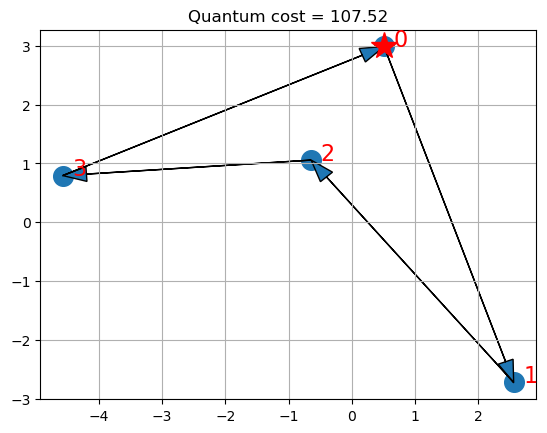

In [17]:
# Put the solution in a way that is compatible with the classical variables
x_quantum = np.zeros(n**2)
kk = 0
for ii in range(n**2):
    if ii // n != ii % n:
        x_quantum[ii] = quantum_solution[kk]
        kk += 1


# visualize the solution
visualize_solution(xc, yc, x_quantum, quantum_cost, n, K, "Quantum")

# and visualize the classical for comparison
if x is not None:
    visualize_solution(xc, yc, x, classical_cost, n, K, "Classical")

The plots present the depot with a star and the selected routes for the vehicles with arrows. Note that in this particular case, we can find the optimal solution of the QP formulation, which happens to coincide with the optimal solution of the ILP.

Keep in mind that VQE is an heuristic working on the QP formulation of the Ising Hamiltonian, though. For suitable choices of A, local optima of the QP formulation will be feasible solutions to the ILP. While for some small instances, as above, we can find optimal solutions of the QP formulation which coincide with optima of the ILP, finding optimal solutions of the ILP is harder than finding local optima of the QP formulation, in general, which in turn is harder than finding feasible solutions of the ILP. Even within the VQE, one may provide stronger guarantees, for specific variational forms (trial wave functions). 

In [18]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright